In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath('')))
from src.data_processing import *
from src.plotting import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
organized_data_folder = "/ceph/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30-03-2022/"
processed_data_folder = "/nfs/gatsbystor/nicholasg/striatal_replay/processed_data"

In [3]:
back_pos_df = pd.read_hdf(os.path.join(organized_data_folder, "video", "tracking", "2_task", "back_2022-03-30T15_02_32DLC_resnet50_task-tracking_backviewApr6shuffle1_800000.h5"), "df_with_missing")
back_pos_df

scorer    DLC_resnet50_task-tracking_backviewApr6shuffle1_800000              \
bodyparts                                               left_ear               
coords                                                         x           y   
0                                                 314.677002      613.623718   
1                                                 313.086517      614.376526   
2                                                 312.222565      613.870911   
3                                                 311.177704      612.852966   
4                                                 310.787781      611.551819   
...                                                      ...             ...   
164722                                            989.293640      857.788208   
164723                                            988.615112      857.374207   
164724                                            988.083984      856.993591   
164725                                            955.039307      866.663452   
164726                                            956.424561      867.342285   

scorer                                                                \
bodyparts               right_ear                        head_centre   
coords    likelihood            x           y likelihood           x   
0           0.999978   415.459747  584.644348   0.999604  366.061066   
1           0.999953   413.810455  585.311279   0.999321  365.491608   
2           0.999975   413.822693  586.121765   0.998607  364.315460   
3           0.999987   413.189178  586.227722   0.998934  363.241913   
4           0.999992   412.628723  586.373962   0.998626  362.535126   
...              ...          ...         ...        ...         ...   
164722      0.000330   986.457764  860.715210   0.000199  987.314392   
164723      0.000512   986.021301  860.786255   0.000290  986.755371   
164724      0.000154  1007.383057  859.719727   0.000096  972.169067   
164725      0.000064  1005.881165  860.325500   0.000041  973.527893   
164726      0.000069  1005.867676  860.115112   0.000076  973.936096   

scorer                                                                  \
bodyparts                        implant_centre                          
coords              y likelihood              x           y likelihood   
0          584.250671   0.999597     359.682373  539.862183   0.999956   
1          585.148315   0.999591     358.531738  539.472961   0.999967   
2          585.561768   0.999709     357.101898  539.707642   0.999975   
3          585.304504   0.999731     356.216064  539.854858   0.999977   
4          584.520691   0.999748     355.045410  539.468933   0.999981   
...               ...        ...            ...         ...        ...   
164722     862.659119   0.000177     989.887695  862.560730   0.996058   
164723     862.310120   0.000294     991.325806  863.018066   0.996171   
164724     875.815002   0.000203     991.324463  862.764893   0.979532   
164725     875.611389   0.000064     994.681335  864.246704   0.958143   
164726     876.193542   0.000110     995.533508  864.306396   0.971416   

scorer                                        
bodyparts   tail_base                         
coords              x           y likelihood  
0          526.411133  748.714844   0.999934  
1          526.559326  748.799683   0.999946  
2          526.644531  748.966431   0.999948  
3          526.458740  749.343933   0.999941  
4          526.424377  749.724487   0.999955  
...               ...         ...        ...  
164722     986.789673  858.737671   0.000325  
164723     986.416260  858.764221   0.000532  
164724     773.706116  956.426575   0.000122  
164725     773.701233  956.396301   0.000094  
164726     773.485901  956.369995   0.000062  

[164727 rows x 15 columns]

In [4]:
back_ports_df = pd.read_hdf(os.path.join(organized_data_folder, "video", "tracking", "2_task", "back_2022-03-30T15_02_32DLC_resnet50_port-tracking_back_viewMay2shuffle1_500000.h5"), "df_with_missing")
back_ports_df

scorer    DLC_resnet50_port-tracking_back_viewMay2shuffle1_500000              \
bodyparts                                                   port2               
coords                                                          x           y   
0                                                 539.760559       632.626099   
1                                                 539.825745       632.553162   
2                                                 540.229858       632.301697   
3                                                 540.206665       632.321167   
4                                                 540.216003       632.320312   
...                                                      ...              ...   
164722                                            539.439392       630.837463   
164723                                            539.423096       630.836975   
164724                                            539.477478       630.818542   
164725                                            539.448669       630.819702   
164726                                            539.438721       630.775330   

scorer                                                               \
bodyparts                  port1                              port6   
coords    likelihood           x           y likelihood           x   
0           0.211554  538.751221  630.036011   0.970708  540.977051   
1           0.366904  538.636902  629.978943   0.942097  541.005615   
2           0.482847  538.679810  629.849976   0.912612  540.971008   
3           0.438246  538.718201  629.988586   0.920505  541.000366   
4           0.535277  538.661682  629.881653   0.889066  541.014099   
...              ...         ...         ...        ...         ...   
164722      0.998269  407.488617  628.166199   0.999983  534.502380   
164723      0.998220  407.458984  628.165649   0.999983  534.037354   
164724      0.998497  407.475922  628.160034   0.999981  535.817627   
164725      0.998540  407.430084  628.199158   0.999982  538.270020   
164726      0.998666  407.497437  628.210327   0.999982  539.001038   

scorer                                                               \
bodyparts                              port3                          
coords              y likelihood           x           y likelihood   
0          505.734894   0.999827  676.380493  631.940613   0.999951   
1          505.765503   0.999863  676.362122  631.970947   0.999957   
2          505.684296   0.999870  676.423889  631.904724   0.999958   
3          505.680298   0.999873  676.451416  631.921448   0.999959   
4          505.676971   0.999881  676.511658  631.835022   0.999959   
...               ...        ...         ...         ...        ...   
164722     509.325989   0.145076  676.588928  636.191956   0.999567   
164723     512.403137   0.288575  676.673462  635.947693   0.999655   
164724     511.911926   0.953766  676.931152  635.673279   0.999811   
164725     512.051575   0.999509  677.153076  634.733093   0.999836   
164726     511.601501   0.999840  677.775024  633.866821   0.999846   

scorer                                        
bodyparts       port7                         
coords              x           y likelihood  
0          679.409729  506.589691   0.999850  
1          679.371094  506.440277   0.999857  
2          679.413330  506.569702   0.999857  
3          679.378479  506.626038   0.999858  
4          679.356323  506.615875   0.999870  
...               ...         ...        ...  
164722     678.733398  507.431793   0.999968  
164723     678.796509  507.476868   0.999969  
164724     678.736816  507.576233   0.999972  
164725     678.618835  507.562042   0.999971  
164726     678.653625  507.614349   0.999972  

[164727 rows x 15 columns]

In [5]:
behavioral_data = pd.read_csv(os.path.join(organized_data_folder, "behav_sync", "2_task", "Behav_Ephys_Camera_Sync.csv"), index_col=0)
display(behavioral_data.columns)
behavioral_data

Index(['Trial_id', 'Trial_Start', 'Port', 'PokeIn_Time', 'PokeOut_Time',
       'Reward_Times', 'Trial_End', 'Port_2-3-4-5_LED_intensities',
       'Port_1-2-3-4_RewardAmount', 'TrainingLevel', 'TrialStart_EphysTime',
       'FirstPoke_EphysTime', 'PokeIN_EphysTime', 'PokeOUT_EphysTime',
       'backcam_trialstart_seconds', 'backcam_aligned_pokein_times',
       'backcam_aligned_pokeout_times', 'backcam_trialstart_timestamps',
       'sidecam_trialstart_seconds', 'sidecam_aligned_pokein_times',
       'sidecam_aligned_pokeout_times', 'sidecam_trialstart_timestamps',
       'bottomcam_trialstart_seconds', 'bottomcam_aligned_pokein_times',
       'bottomcam_aligned_pokeout_times', 'bottomcam_trialstart_timestamps'],
      dtype='object')

,Trial_id,Trial_Start,Port,PokeIn_Time,PokeOut_Time,Reward_Times,Trial_End,Port_2-3-4-5_LED_intensities,Port_1-2-3-4_RewardAmount,TrainingLevel,...,backcam_aligned_pokeout_times,backcam_trialstart_timestamps,sidecam_trialstart_seconds,sidecam_aligned_pokein_times,sidecam_aligned_pokeout_times,sidecam_trialstart_timestamps,bottomcam_trialstart_seconds,bottomcam_aligned_pokein_times,bottomcam_aligned_pokeout_times,bottomcam_trialstart_timestamps
0,1,33.5779,7,39.1177,39.3896,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,347.811700,20520.0,342.000000,347.539800,347.811700,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
1,1,33.5779,7,39.5222,39.7818,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,348.203900,20520.0,342.000000,347.944300,348.203900,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2,1,33.5779,7,45.3722,45.9151,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,354.337200,20520.0,342.000000,353.794300,354.337200,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
3,1,33.5779,1,46.7517,47.4965,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,355.918600,20520.0,342.000000,355.173800,355.918600,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
4,1,33.5779,3,49.2089,49.3717,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,357.793800,20520.0,342.000000,357.631000,357.793800,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,277,2411.2686,6,2414.8285,2415.0117,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2724.709767,163258.0,2720.966667,2724.526567,2724.709767,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2178,277,2411.2686,3,2415.3505,2415.7008,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2725.398867,163258.0,2720.966667,2725.048567,2725.398867,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2179,277,2411.2686,2,2415.3840,2415.5804,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2725.278467,163258.0,2720.966667,2725.082067,2725.278467,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2180,277,2411.2686,2,2415.5868,2415.6890,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2725.387067,163258.0,2720.966667,2725.284867,2725.387067,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data


In [6]:
correct_seqs_indices = find_correct_seq_indices(behavioral_data)
correct_seqs = behavioral_data.iloc[correct_seqs_indices]
correct_seqs

,Trial_id,Trial_Start,Port,PokeIn_Time,PokeOut_Time,Reward_Times,Trial_End,Port_2-3-4-5_LED_intensities,Port_1-2-3-4_RewardAmount,TrainingLevel,...,backcam_aligned_pokeout_times,backcam_trialstart_timestamps,sidecam_trialstart_seconds,sidecam_aligned_pokein_times,sidecam_aligned_pokeout_times,sidecam_trialstart_timestamps,bottomcam_trialstart_seconds,bottomcam_aligned_pokein_times,bottomcam_aligned_pokeout_times,bottomcam_trialstart_timestamps
17,1,33.5779,2,61.4296,61.8883,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,370.310400,20520.0,342.000000,369.851700,370.310400,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
18,1,33.5779,1,63.1067,63.4154,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,371.837500,20520.0,342.000000,371.528800,371.837500,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
19,1,33.5779,6,64.3364,64.5665,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,372.988600,20520.0,342.000000,372.758500,372.988600,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
20,1,33.5779,3,64.9775,65.1747,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,373.596800,20520.0,342.000000,373.399600,373.596800,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
21,1,33.5779,7,65.5319,66.7492,65.5319,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,375.171300,20520.0,342.000000,373.954000,375.171300,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2170,276,2406.9343,1,2408.3064,2408.4858,NaN,2411.2683,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2718.184833,162998.0,2716.633333,2718.005433,2718.184833,162998.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2171,276,2406.9343,6,2409.0497,2409.2679,NaN,2411.2683,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2718.966933,162998.0,2716.633333,2718.748733,2718.966933,162998.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2172,276,2406.9343,3,2409.6475,2409.8396,NaN,2411.2683,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2719.538633,162998.0,2716.633333,2719.346533,2719.538633,162998.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2173,276,2406.9343,3,2410.0185,2410.4540,NaN,2411.2683,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2720.153033,162998.0,2716.633333,2719.717533,2720.153033,162998.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data


In [15]:
# Only run this once to generate the ports data frame. This will save a file called "ports.csv" into the processed_data_folder. Skip this if the ports data frame is already generated and ready to be loaded, which will save time.

port_names = back_ports_df.columns.get_level_values(1).unique().to_list()
port_points = np.zeros((2, len(port_names)))

for i, port_name in enumerate(port_names):
    port_data = back_ports_df.loc[:, (slice(None), port_name, ["x", "y", "likelihood"])]
    port_data = filter_df_on_likelihood(port_data, 0.999)
    port_point = extract_centre_point_using_histogram(port_data)
    port_points[:,i] = port_point

ports_x_position = port_points[0]
ports_y_position = port_points[1]

track_segment_lengths = np.sqrt(np.diff(port_points[0])**2 + np.diff(port_points[1])**2)
track_segment_vecs = np.diff(port_points, axis=1)
cumulative_track_segment_length = np.cumsum(track_segment_lengths)
cumulative_track_segment_length = np.insert(cumulative_track_segment_length, 0, 0)

ports = pd.DataFrame({
    "x_position": ports_x_position,
    "y_position": ports_y_position,
    "linear_position": cumulative_track_segment_length
}, index = [name[-1] for name in port_names])

ports.to_csv(os.path.join(processed_data_folder, "ports.csv"))
display(ports)

,x_position,y_position,linear_position
2,535.420206,627.221570,0.000000
1,397.396156,621.255591,138.152927
6,537.683478,494.916093,326.944349
3,677.354724,623.760257,516.967704
7,673.807230,497.948122,642.829843


In [17]:
# Only run this once to generate the trajectories data frame. 
# This will save a file called "trajectories.csv" into the processed_data_folder. 
# Skip this if the trajectories data frame is already generated and ready to be loaded, which will save time.

keypoint_df = calculate_average_keypoint(back_pos_df, keypoint_cols=["head_centre"])
sync_file = os.path.join(organized_data_folder,"behav_sync", "2_task", "Transition_data_sync.csv")
sync_df = pd.read_csv(sync_file)
camera_sync_times = get_camera_sync_times(keypoint_df, sync_df)

trajectories = {
    "trial_id": [],
    "camera_idx": [],
    "camera_time": [],
    "ephys_time": [],
    "linear_position": [],
    "x_position": [],
    "y_position": [],
    "port1": [],
    "port2": [],
    "linear_offset": [],
    "trajectory_start_idx": [],
    "trajectory_end_idx": []
}

for i, (port1_name, port2_name) in enumerate(zip(port_names[:-1], port_names[1:])):

    port1 = int(port1_name[-1])
    port2 = int(port2_name[-1])
    port1_df = correct_seqs[correct_seqs["Port"] == port1].groupby("Trial_id").agg("last")
    port2_df = correct_seqs[correct_seqs["Port"] == port2].groupby("Trial_id").agg("first")

    start_time_col="backcam_aligned_pokein_times"
    end_time_col="backcam_aligned_pokein_times"

    starts_ends_times_seqs = get_starts_ends_of_sequence(port1_df, 
                                                     port2_df,
                                                     start_time_col,
                                                     end_time_col)
    
    tracking_idxs_df = get_camera_times_from_times_df(starts_ends_times_seqs, camera_sync_times)

    linear_offset = cumulative_track_segment_length[i]
    track_segment_vec = track_segment_vecs[:,i]
    track_segment_point = port_points[:,i]
    track_segment_length = track_segment_lengths[i]

    for j, (start_idx, end_idx) in tracking_idxs_df.iterrows():

        trial_id = port1_df.loc[j].name

        trajectory = keypoint_df.iloc[start_idx:end_idx]
        trajectory_start = trajectory.iloc[0]
        trajectory_end = trajectory.iloc[-1]
        segment_vec = trajectory_end - trajectory_start
        
        magnitude = np.dot(segment_vec, segment_vec)
        projection = np.dot((trajectory - trajectory_start), segment_vec) / magnitude
        linear_trajectory = projection * np.linalg.norm(track_segment_vec) + linear_offset

        for k, pos in enumerate(linear_trajectory):
            trajectories["trial_id"].append(trial_id)
            trajectories["camera_idx"].append(start_idx + k)
            trajectories["camera_time"].append(camera_sync_times.iloc[start_idx + k]["camera_time"])
            trajectories["ephys_time"].append(camera_sync_times.iloc[start_idx + k]["ephys_time"])
            trajectories["linear_position"].append(linear_trajectory[k])
            trajectories["x_position"].append(trajectory["x"].iloc[k])
            trajectories["y_position"].append(trajectory["y"].iloc[k])
            trajectories["port1"].append(port1)
            trajectories["port2"].append(port2)
            trajectories["linear_offset"].append(linear_offset)
            trajectories["trajectory_start_idx"].append(start_idx)
            trajectories["trajectory_end_idx"].append(end_idx)

trajectories = pd.DataFrame(trajectories, index=trajectories["camera_idx"]).sort_index()
trajectories.to_csv(os.path.join(processed_data_folder, "trajectories.csv"))
display(trajectories)

,trial_id,camera_idx,camera_time,ephys_time,linear_position,x_position,y_position,port1,port2,linear_offset,trajectory_start_idx,trajectory_end_idx
22191,1,22191,369.857173,4800.884355,0.000000,670.492310,513.852478,2,1,0.000000,22191,22291
22192,1,22192,369.873841,4800.901010,-0.607927,671.156128,512.822449,2,1,0.000000,22191,22291
22193,1,22193,369.890509,4800.917665,-0.010407,670.305847,513.338928,2,1,0.000000,22191,22291
22194,1,22194,369.907178,4800.934320,0.082560,670.071716,513.164001,2,1,0.000000,22191,22291
22195,1,22195,369.923846,4800.950974,0.010824,670.314087,513.453674,2,1,0.000000,22191,22291
...,...,...,...,...,...,...,...,...,...,...,...,...
163228,276,163228,2720.473922,7150.310765,597.237558,650.354614,576.198364,3,7,516.967704,163183,163233
163229,276,163229,2720.490593,7150.327440,606.095453,654.041809,570.472900,3,7,516.967704,163183,163233
163230,276,163230,2720.507265,7150.344115,616.064659,655.980164,564.733582,3,7,516.967704,163183,163233
163231,276,163231,2720.523936,7150.360789,627.483287,657.201050,558.478149,3,7,516.967704,163183,163233


In [9]:
trajectories = pd.read_csv(os.path.join(processed_data_folder, "trajectories.csv"), index_col=0)
ports = pd.read_csv(os.path.join(processed_data_folder, "ports.csv"), index_col=0)
display(ports)
display(trajectories)

,x_position,y_position,linear_position
port2,535.420206,627.221570,0.000000
port1,397.396156,621.255591,138.152927
port6,537.683478,494.916093,326.944349
port3,677.354724,623.760257,516.967704
port7,673.807230,497.948122,642.829843


,trial_id,camera_idx,camera_time,ephys_time,linear_position,x_position,y_position,port1,port2,linear_offset,trial_start_idx,trial_end_idx
22191,1,22191,369.857173,4800.884355,0.000000,670.492310,513.852478,2,1,0.000000,22191,22291
22192,1,22192,369.873841,4800.901010,-0.607927,671.156128,512.822449,2,1,0.000000,22191,22291
22193,1,22193,369.890509,4800.917665,-0.010407,670.305847,513.338928,2,1,0.000000,22191,22291
22194,1,22194,369.907178,4800.934320,0.082560,670.071716,513.164001,2,1,0.000000,22191,22291
22195,1,22195,369.923846,4800.950974,0.010824,670.314087,513.453674,2,1,0.000000,22191,22291
...,...,...,...,...,...,...,...,...,...,...,...,...
163228,276,163228,2720.473922,7150.310765,597.237558,650.354614,576.198364,3,7,516.967704,163183,163233
163229,276,163229,2720.490593,7150.327440,606.095453,654.041809,570.472900,3,7,516.967704,163183,163233
163230,276,163230,2720.507265,7150.344115,616.064659,655.980164,564.733582,3,7,516.967704,163183,163233
163231,276,163231,2720.523936,7150.360789,627.483287,657.201050,558.478149,3,7,516.967704,163183,163233


In [10]:
track_segment_vecs

array([[-138.02404938,  140.28732147,  139.67124634,   -3.54749451],
       [  -5.965979  , -126.33949738,  128.84416351, -125.81213531]])

In [14]:
track_segment_vecs = np.diff(np.vstack([ports["x_position"], ports["y_position"]]), axis=1)
track_segment_vecs

array([[-138.02404938,  140.28732147,  139.67124634,   -3.54749451],
       [  -5.965979  , -126.33949738,  128.84416351, -125.81213531]])

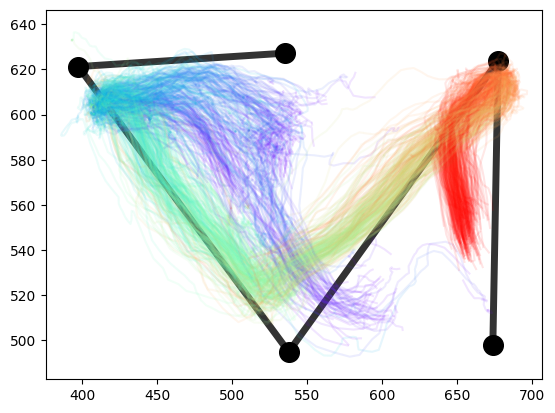

In [10]:
ax = plot_all_trajectories(trajectories, ports, normalize_color=False, clim=(0, 120)) # Normalized across trials by time - blue t = 0s, red t > 2s.
# ax = plot_all_trajectories(trajectories, ports) # Normalized within trials by time - blue t = start, red t = end.

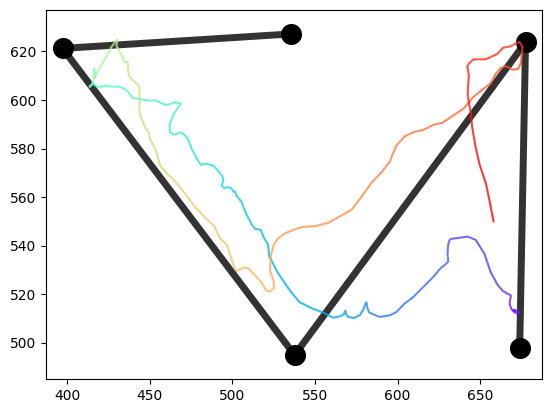

In [11]:
ax = plot_single_trajectory(trajectories, ports, trial_id = 1)

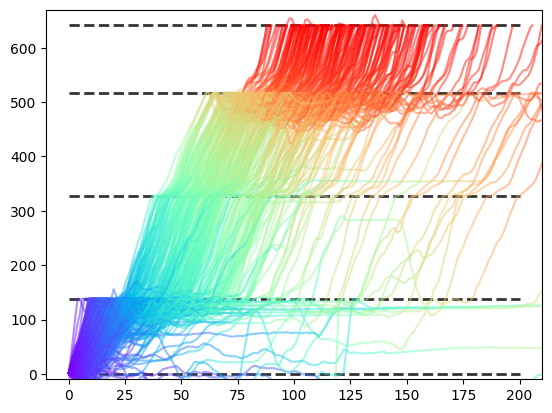

In [12]:
ax = plot_all_trajectories_linear(trajectories, ports, alpha = 0.5, x_range = (0, 200), y_range = (0, trajectories["linear_position"].max())) # Normalized within trials
# ax = plot_all_trajectories_linear(trajectories, ports, normalize_color = False, clim = (0, 120), alpha = 0.5, x_range = (0, 200), y_range = (0, trajectories["linear_position"].max())) # Normalized across trials by time

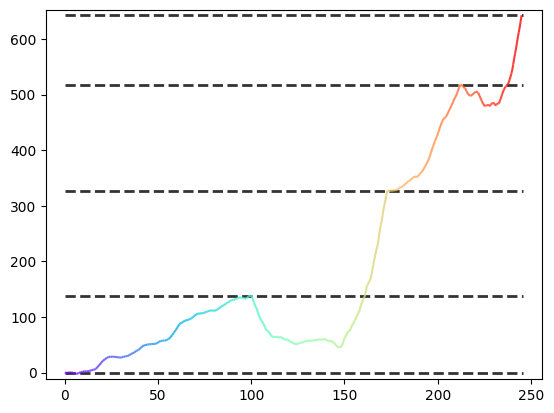

In [13]:
ax = plot_single_trajectory_linear(trajectories, ports, trial_id=1)

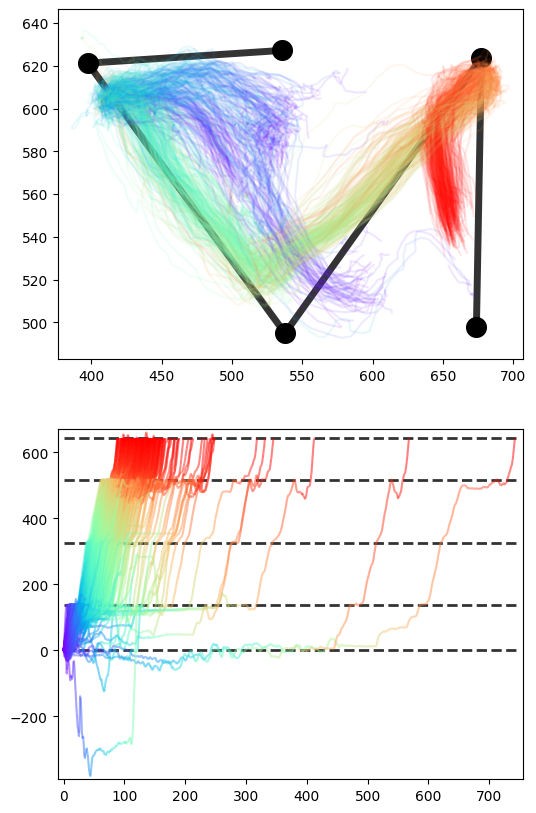

In [14]:
fig = plt.Figure(figsize=(6,10))
ax = fig.add_axes(211)
ax = plot_all_trajectories(trajectories, ports, ax=ax)
ax = fig.add_axes(212)
ax = plot_all_trajectories_linear(trajectories, ports, ax=ax, alpha = 0.5)
display(fig)

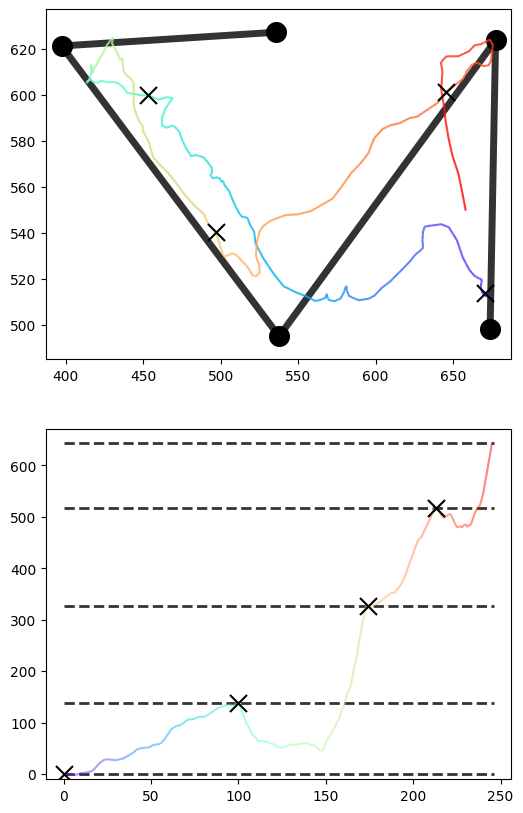

In [17]:
trial_id = 1

fig = plt.Figure(figsize=(6,10))
ax = fig.add_axes(211)
ax = plot_single_trajectory(trajectories, ports, ax=ax, trial_id=trial_id)
trial_df = trajectories[trajectories["trial_id"] == trial_id]
grouped_trial_df = trial_df.groupby("port1").agg("first").sort_values("camera_idx")
x = trial_df.loc[grouped_trial_df.camera_idx.values]["x_position"]
y = trial_df.loc[grouped_trial_df.camera_idx.values]["y_position"]
ax.scatter(x, y, s = 150, c = "black", marker="x", zorder=4)

ax = fig.add_axes(212)
ax = plot_single_trajectory_linear(trajectories, ports, trial_id=trial_id, ax=ax, alpha = 0.5, y_range = (0, trajectories["linear_position"].max()))
x = grouped_trial_df["camera_idx"] - grouped_trial_df.iloc[0]["camera_idx"]
y = grouped_trial_df["linear_position"]
ax.scatter(x, y, s = 150, c = "black", marker="x", zorder=4)
display(fig)

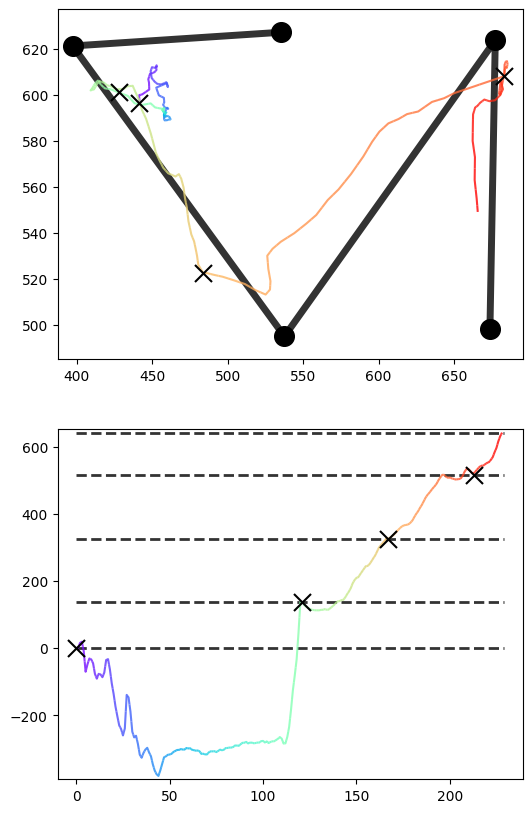

In [24]:
trial_id = trajectories[trajectories["linear_position"] == trajectories["linear_position"].min()]["trial_id"].item()

fig = plt.Figure(figsize=(6,10))
ax = fig.add_axes(211)
ax = plot_single_trajectory(trajectories, ports, ax=ax, trial_id=trial_id)
trial_df = trajectories[trajectories["trial_id"] == trial_id]
grouped_trial_df = trial_df.groupby("port1").agg("first").sort_values("camera_idx")
x = trial_df.loc[grouped_trial_df.camera_idx.values]["x_position"]
y = trial_df.loc[grouped_trial_df.camera_idx.values]["y_position"]
ax.scatter(x, y, s = 150, c = "black", marker="x", zorder=4)

ax = fig.add_axes(212)
ax = plot_single_trajectory_linear(trajectories, ports, trial_id=trial_id, ax=ax)
x = grouped_trial_df["camera_idx"] - grouped_trial_df.iloc[0]["camera_idx"]
y = grouped_trial_df["linear_position"]
ax.scatter(x, y, s = 150, c = "black", marker="x", zorder=4)
display(fig)